In [1]:
# Import dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import ttest_rel
import random

In [2]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [3]:
# Create engine

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Query to find the most recent date in the table (last data point in database)

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Display the date

last_date

('2017-08-23')

In [9]:
# Calculate the date 1 year ago from the last data point in the database

year_start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Display the date

year_start_date

datetime.date(2016, 8, 23)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data 

precip_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_start_date).all()

# Create data frame that displays only the date and precipitation data for the dates selected (precip_query)

precip_df = pd.DataFrame(precip_query, columns=['Date', 'Precipitation'])

# Get rid of NaN values and sort values by date in ascending order

precip_df_clean = (precip_df.dropna()).sort_values(by="Date")

# Preview the data frame

precip_df_clean.head()

,Date,Precipitation
0,2016-08-24,0.08
1188,2016-08-24,1.22
702,2016-08-24,2.28
1875,2016-08-24,1.45
360,2016-08-24,2.15


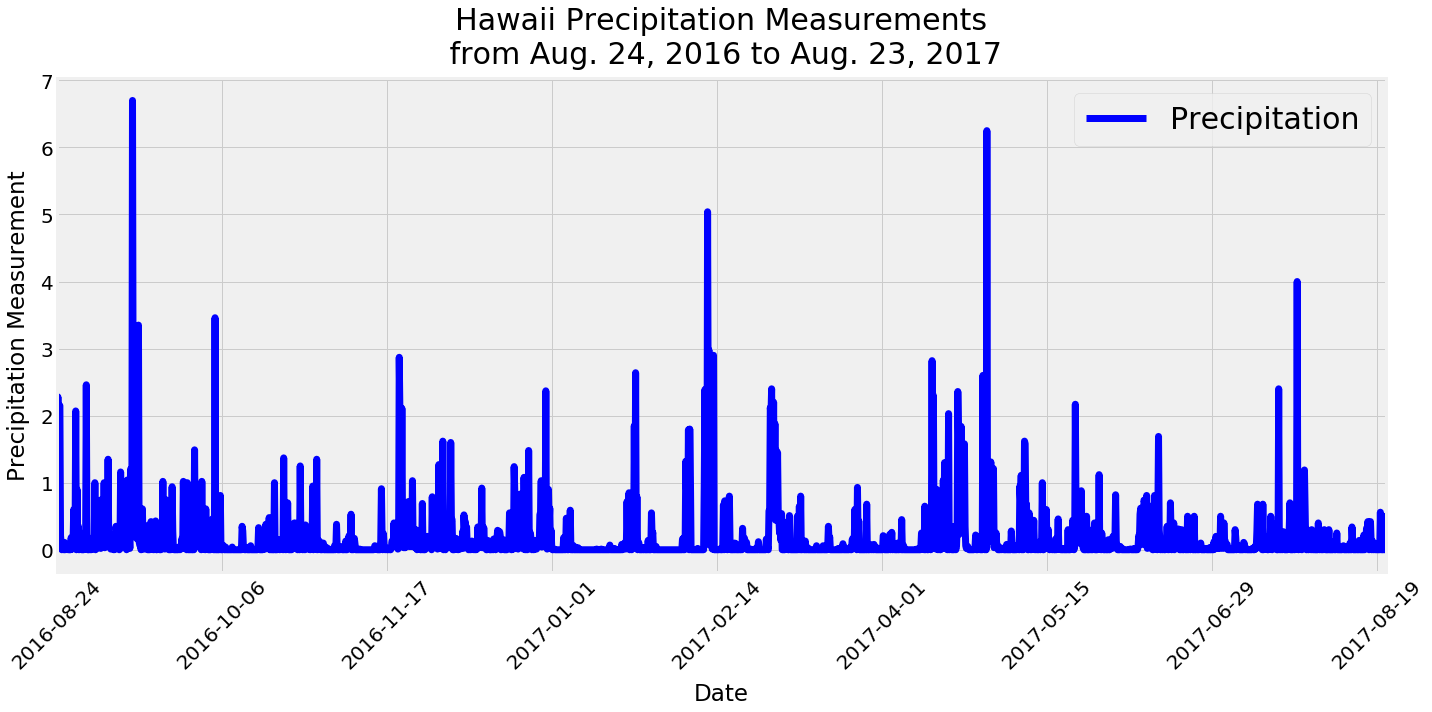

In [11]:
# Graph the data

graph_1 = precip_df_clean.plot(x="Date", y="Precipitation", kind="line", figsize=(20,10), fontsize=20, linewidth=7, color="blue", rot=45)

plt.legend(prop={"size":30}, loc="best")
plt.xlabel("Date", fontsize=23, labelpad=10)
plt.ylabel("Precipitation Measurement", fontsize=23, labelpad=10)
plt.title("Hawaii Precipitation Measurements\n from Aug. 24, 2016 to Aug. 23, 2017", fontsize=30, pad=15)

plt.tight_layout()

plt.savefig("Images/Hawaii_Precipitation_Measurements.png") 

plt.show(graph_1)

plt.close()

In [12]:
# Calcualte the summary statistics for the precipitation data

precip_df_clean.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [13]:
# Query how many stations are in the data set
# To make sure that all stations are unique, use group_by station and count the number of stations

total_stations = session.query(Station).group_by(Station.station).count()

# Display the count

total_stations

9

In [14]:
# Print out the number of stations

print(f"There are a total of {total_stations} different stations on Hawaii based on the data set provided.")

There are a total of 9 different stations on Hawaii based on the data set provided.


In [15]:
# List the stations and the counts in descending order to find the most active stations

station_activity_level = session.query(Measurement.station, func.count(Measurement.station)).\
                         group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc()).all()

# Display the data

station_activity_level

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Convert the data into a data frame for better visualization

sta_act_df = pd.DataFrame(station_activity_level, columns=["Station","Observation Count"])

# Display the data frame

sta_act_df

,Station,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [17]:
# Display the station with the most observations and provide the activity count

sta_most_act = sta_act_df.iat[0,0]
sta_obs_count = sta_act_df.iat[0,1]

# Print the station and activity

print(f"The station with the most activity is Station {sta_most_act} with {sta_obs_count} observations.") 

The station with the most activity is Station USC00519281 with 2772 observations.


In [18]:
# Query to get info for the station with the most activity

most_active_station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.count(Measurement.station)).\
            filter(Measurement.station == Station.station).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()

# Print the data

print("Station with Most Activity Info:")
most_active_station_info

Station with Most Activity Info:


('USC00519281',
 'WAIHEE 837.5, HI US',
 21.45167,
 -157.84888999999998,
 32.9,
 2772)

In [19]:
# Query to find the lowest temperature recorded, highest temperature recorded, and average temperature of most active station

act_station_temp_data = session.query(func.min(Measurement.tobs), 
                                      func.max(Measurement.tobs),
                                      func.avg(Measurement.tobs)
                                     ).filter(Measurement.station == sta_most_act).all()

# Display the data

act_station_temp_data

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Convert the data into a data frame for better visualization

act_station_data_df = pd.DataFrame(act_station_temp_data, index=[f"Station: {sta_most_act}"], columns=["Min Temp (F)", "Max Temp (F)", "Average Temp (F)"])

# Display the data frame

act_station_data_df

,Min Temp (F),Max Temp (F),Average Temp (F)
Station: USC00519281,54.0,85.0,71.663781


In [21]:
# Query to retrieve the last 12 months of temperature observation data (tobs)

temp_query = session.query(Measurement.station, Measurement.tobs).\
                     filter(Measurement.date > year_start_date).all()

# Display first 10 of list

temp_query[:10]


[('USC00519397', 79.0),
 ('USC00519397', 80.0),
 ('USC00519397', 79.0),
 ('USC00519397', 77.0),
 ('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 79.0),
 ('USC00519397', 80.0),
 ('USC00519397', 81.0),
 ('USC00519397', 80.0)]

In [22]:
# Convert the data into a data frame for better visualization

temp_query_df = pd.DataFrame(temp_query, columns=["Station","Temp Observed"])

# Display the data frame

temp_query_df.head()

,Station,Temp Observed
0,USC00519397,79.0
1,USC00519397,80.0
2,USC00519397,79.0
3,USC00519397,77.0
4,USC00519397,78.0


In [23]:
# Find the station with the most temperature observations by using value_counts() and converting the data into a data frame

station_temp_df = pd.DataFrame(temp_query_df["Station"].value_counts())

# Display the data frame

station_temp_df

,Station
USC00519397,360
USC00519281,351
USC00516128,348
USC00513117,342
USC00519523,336
USC00514830,304
USC00517948,182


In [24]:
# Find the station with the highest temperature observations

highest_obs_station = station_temp_df.index[0]

# Print the data in a sentence 

print(f"The station with the highest number of temperature observations is Station {highest_obs_station}.")

The station with the highest number of temperature observations is Station USC00519397.


In [25]:
# Query to find the data for specific station

temp_sta_USC00519397_year = session.query(Measurement.station, Measurement.tobs).\
                                    filter(Measurement.date > year_start_date).\
                                    filter(Measurement.station == highest_obs_station).all()

# Preview the data

temp_sta_USC00519397_year[:10]

[('USC00519397', 79.0),
 ('USC00519397', 80.0),
 ('USC00519397', 79.0),
 ('USC00519397', 77.0),
 ('USC00519397', 78.0),
 ('USC00519397', 78.0),
 ('USC00519397', 79.0),
 ('USC00519397', 80.0),
 ('USC00519397', 81.0),
 ('USC00519397', 80.0)]

In [26]:
# Convert data into a data frame

temp_sta_USC00519397_year_df = pd.DataFrame(temp_sta_USC00519397_year, columns=["Station", "Temperature"])

# Preview the data frame

temp_sta_USC00519397_year_df_clean = (temp_sta_USC00519397_year_df.dropna()).set_index("Station")

temp_sta_USC00519397_year_df_clean.head()

,Temperature
Station,
USC00519397,79.0
USC00519397,80.0
USC00519397,79.0
USC00519397,77.0
USC00519397,78.0


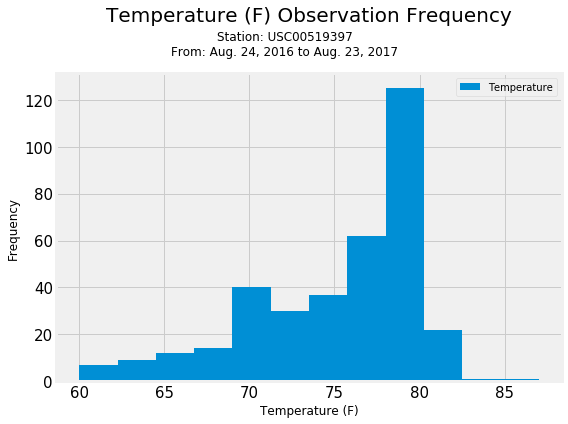

In [27]:
# Graph the data

graph_2 = temp_sta_USC00519397_year_df_clean.plot.hist(bins=12, figsize=(8,6), fontsize=15)

plt.title("Temperature (F) Observation Frequency", fontsize=20, pad=52)
plt.suptitle("Station: USC00519397\nFrom: Aug. 24, 2016 to Aug. 23, 2017", y=0.92)
plt.xlabel("Temperature (F)")

plt.tight_layout()

plt.savefig("Images/Temperature_Observation Frequency.png")

plt.show(graph_2)

plt.close()

# Temperature Analysis I

In [28]:
june_prcp = session.query(Measurement.date, Measurement.tobs).\
            filter(extract("month", Measurement.date)==6).all()

june_prcp[:10]


[('2010-06-01', 78.0),
 ('2010-06-02', 76.0),
 ('2010-06-03', 78.0),
 ('2010-06-04', 76.0),
 ('2010-06-05', 77.0),
 ('2010-06-06', 78.0),
 ('2010-06-07', 77.0),
 ('2010-06-08', 78.0),
 ('2010-06-09', 78.0),
 ('2010-06-10', 79.0)]

In [29]:
june_prcp_df = pd.DataFrame(june_prcp, columns=["Date", "tobs"])
june_prcp_df.head()

,Date,tobs
0,2010-06-01,78.0
1,2010-06-02,76.0
2,2010-06-03,78.0
3,2010-06-04,76.0
4,2010-06-05,77.0


In [30]:
june_avg_temp = june_prcp_df["tobs"].mean()
print("The average temperature in June in Hawaii:")
june_avg_temp

The average temperature in June in Hawaii:


74.94411764705882

In [31]:
dec_prcp = session.query(Measurement.date, Measurement.tobs).\
           filter(extract("month", Measurement.date)==12).all()

dec_prcp[:10]

[('2010-12-01', 76.0),
 ('2010-12-03', 74.0),
 ('2010-12-04', 74.0),
 ('2010-12-06', 64.0),
 ('2010-12-07', 64.0),
 ('2010-12-08', 67.0),
 ('2010-12-09', 77.0),
 ('2010-12-10', 66.0),
 ('2010-12-11', 69.0),
 ('2010-12-12', 68.0)]

In [32]:
dec_prcp_df = pd.DataFrame(dec_prcp, columns=["Date", "tobs"])
dec_prcp_df.head()

,Date,tobs
0,2010-12-01,76.0
1,2010-12-03,74.0
2,2010-12-04,74.0
3,2010-12-06,64.0
4,2010-12-07,64.0


In [33]:
dec_avg_temp = dec_prcp_df["tobs"].mean()

print("The average temperature in December in Hawaii:")

dec_avg_temp

The average temperature in December in Hawaii:


71.04152933421226

In [34]:
len(june_prcp_df)

1700

In [35]:
len(dec_prcp_df)

1517

In [36]:
# I am using a paired t-test because the temperature measurement are on the same thing - the weather in Hawaii. 
# We are comparing the temperatures in Hawaii at two different times of the year. 
# Because the number of tobs for June and December are not equal, I selected random tobs from both June and December in equal quantities (1500)

t_test = ttest_rel(random.sample(june_prcp_df["tobs"].to_list(), 1500), random.sample(dec_prcp_df["tobs"].to_list(), 1500))

# Display the results

t_test

Ttest_relResult(statistic=30.38918727206996, pvalue=1.906183484011237e-158)

The p-value is 2.6236536889141893e-167, which is significantly less than the standard thresholds of 0.05 or 0.01. There is a statistically significant difference between the tempertures in Hawaii in June versus December.

# Temperature Analysis II

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Set to variable to be used later

temp_trip = calc_temps("2016-12-01", "2016-12-12")

# Print the results

print(temp_trip)

[(65.0, 71.02597402597402, 78.0)]


In [38]:
# Conver the data to a data frame for better visualization and to graph

temp_trip_df = pd.DataFrame(temp_trip, index = ["Hawaii Temperature (F)"], columns=["Lowest", "Average", "Highest"])

# Display the data frame 

temp_trip_df

,Lowest,Average,Highest
Hawaii Temperature (F),65.0,71.025974,78.0


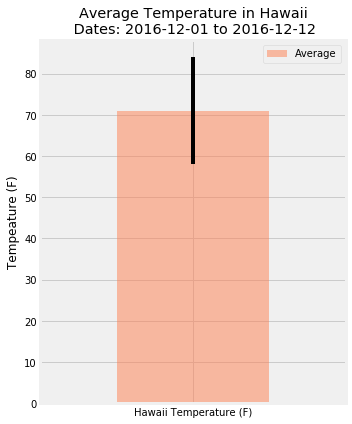

In [39]:
# Plot the data using a bar plot with yerr

graph_3 = temp_trip_df.plot.bar(y='Average', 
                                yerr=(temp_trip_df["Highest"] - temp_trip_df["Lowest"]), 
                                title="Average Temperature in Hawaii\n Dates: 2016-12-01 to 2016-12-12", 
                                color='coral', alpha=0.5, figsize=(5,6), rot=0)
plt.ylabel("Tempeature (F)")

plt.tight_layout()

plt.savefig("Images/Average_Temperature_Hawaii.png")

plt.show(graph_3)

plt.close()

# Daily Rainfall Average

In [40]:
# Define start and end date for Hawaii trip

trip_start_date = "2017-12-01"
trip_end_date = "2017-12-12"

# Get the date range

trip_date_range = pd.date_range(trip_start_date, trip_end_date)

# Conver the date range into a list to be used later

trip_date_list = []
for date in trip_date_range:
    trip_date_list.append(date.strftime("%Y-%m-%d"))

# Display list

trip_date_list

['2017-12-01',
 '2017-12-02',
 '2017-12-03',
 '2017-12-04',
 '2017-12-05',
 '2017-12-06',
 '2017-12-07',
 '2017-12-08',
 '2017-12-09',
 '2017-12-10',
 '2017-12-11',
 '2017-12-12']

In [41]:
# Because the daily normal functions use the date without the year, convert trip dates to appropriate format

dates_without_year = [date[5:] for date in trip_date_list]

# Display the list 

dates_without_year

['12-01',
 '12-02',
 '12-03',
 '12-04',
 '12-05',
 '12-06',
 '12-07',
 '12-08',
 '12-09',
 '12-10',
 '12-11',
 '12-12']

In [42]:
# Calculate the rainfall per weather station using the previous year's matching dates

total_rain_by_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                                join(Station, Measurement.station==Station.station).\
                                group_by(Measurement.station).\
                                filter(Measurement.date >= "2016-12-01").\
                                filter(Measurement.date <= "2016-12-12").all()

# Convert to a data frame

total_rain_by_station_df = pd.DataFrame(total_rain_by_station, columns=["Station ID", "Station Info", "Latitude", "Longitude", "Elevation", "Precip. Total"])

# Display the data

print("Total Rain by Station from 2016-12-01 to 2016-12-12")
total_rain_by_station_df

Total Rain by Station from 2016-12-01 to 2016-12-12


,Station ID,Station Info,Latitude,Longitude,Elevation,Precip. Total
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.72
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.21
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.17
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.29
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.27
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.28
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.10


In [43]:
# Create function to calculate min, avg, and max daily precipitation normals

def daily_normals_prcp(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.prcp), func.avg(Measurement.prcp), func.max(Measurement.prcp)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# Check to see if function works

daily_normals_prcp("01-01")

[(0.0, 0.07479999999999998, 0.42)]

In [44]:
# Create empty list to append precip data

trip_daily_prcp_normals = []

# Loop through dates to get the min, avg, and max data

for date in dates_without_year:
    dn = daily_normals_prcp(date)
    trip_daily_prcp_normals.append(dn[0])

# Display the list

trip_daily_prcp_normals

[(0.0, 0.17260869565217393, 1.48),
 (0.0, 0.3214893617021276, 2.25),
 (0.0, 0.24612244897959182, 1.82),
 (0.0, 0.18020408163265306, 1.56),
 (0.0, 0.12, 1.6),
 (0.0, 0.04638297872340425, 0.63),
 (0.0, 0.022272727272727274, 0.26),
 (0.0, 0.04106382978723405, 0.53),
 (0.0, 0.10652173913043476, 1.43),
 (0.0, 0.4148979591836735, 2.5),
 (0.0, 0.2636734693877551, 1.5),
 (0.0, 0.17041666666666666, 1.71)]

In [45]:
# Convert to data frame

trip_daily_prcp_normals_df = pd.DataFrame(trip_daily_prcp_normals, columns=["Lowest Precipitation", "Average Precipitation", "Highest Precipitation"])

# Display data frame

trip_daily_prcp_normals_df

,Lowest Precipitation,Average Precipitation,Highest Precipitation
0,0.0,0.172609,1.48
1,0.0,0.321489,2.25
2,0.0,0.246122,1.82
3,0.0,0.180204,1.56
4,0.0,0.120000,1.60
5,0.0,0.046383,0.63
6,0.0,0.022273,0.26
7,0.0,0.041064,0.53
8,0.0,0.106522,1.43
9,0.0,0.414898,2.50


In [46]:
# Append the dates to the data frame and set it to the index

trip_daily_prcp_normals_df["Trip Dates"] = trip_date_list
trip_daily_prcp_normals_df = trip_daily_prcp_normals_df.set_index("Trip Dates")

# Display the updated data frame

trip_daily_prcp_normals_df

,Lowest Precipitation,Average Precipitation,Highest Precipitation
Trip Dates,,,
2017-12-01,0.0,0.172609,1.48
2017-12-02,0.0,0.321489,2.25
2017-12-03,0.0,0.246122,1.82
2017-12-04,0.0,0.180204,1.56
2017-12-05,0.0,0.120000,1.60
2017-12-06,0.0,0.046383,0.63
2017-12-07,0.0,0.022273,0.26
2017-12-08,0.0,0.041064,0.53
2017-12-09,0.0,0.106522,1.43


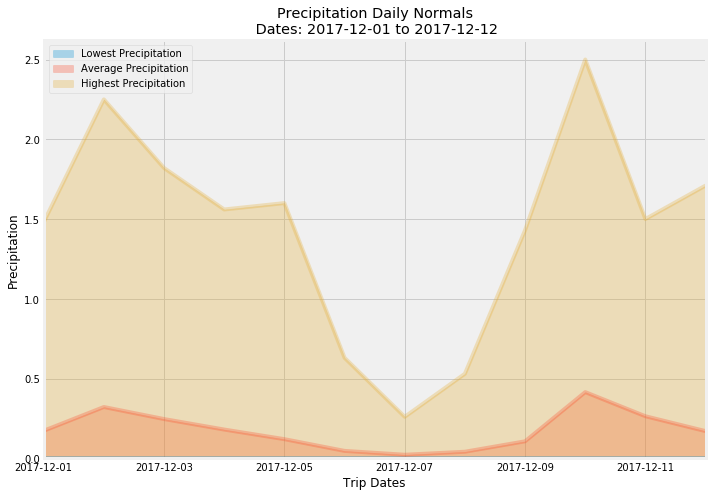

In [47]:
# Graph the data

daily_prcp_graph = trip_daily_prcp_normals_df.plot(kind='area', 
                                         figsize=(10,7), 
                                         alpha=.3, 
                                         stacked=False, 
                                         x_compat=True, 
                                         title="Precipitation Daily Normals\n Dates: 2017-12-01 to 2017-12-12"
                                        )

plt.ylabel("Precipitation")

plt.tight_layout()

plt.savefig("Images/Precipitation_Daily_Normals.png")

plt.show(daily_prcp_graph)

plt.close()

In [48]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# Create empty list to append daily normals to

trip_daily_normals = []

for date in dates_without_year:
    dn = daily_normals(date)
    trip_daily_normals.append(dn[0])

# Display list

trip_daily_normals

[(65.0, 71.91666666666667, 78.0),
 (62.0, 71.32692307692308, 77.0),
 (67.0, 72.88679245283019, 79.0),
 (66.0, 72.17647058823529, 81.0),
 (64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0)]

In [50]:
# Conver to data frame

trip_daily_normals_df = pd.DataFrame(trip_daily_normals, columns=["Lowest Temp (F)", "Average Temp (F)", "Highest Temp (F)"])

# Display data frame

trip_daily_normals_df

,Lowest Temp (F),Average Temp (F),Highest Temp (F)
0,65.0,71.916667,78.0
1,62.0,71.326923,77.0
2,67.0,72.886792,79.0
3,66.0,72.176471,81.0
4,64.0,70.921569,78.0
5,61.0,69.392157,78.0
6,58.0,69.200000,79.0
7,60.0,70.274510,83.0
8,64.0,71.901961,80.0
9,61.0,71.245283,78.0


In [51]:
# Add dates to the data frame and set it to index

trip_daily_normals_df["Trip Dates"] = trip_date_list
trip_daily_normals_df = trip_daily_normals_df.set_index("Trip Dates")

# Display data frame

trip_daily_normals_df

,Lowest Temp (F),Average Temp (F),Highest Temp (F)
Trip Dates,,,
2017-12-01,65.0,71.916667,78.0
2017-12-02,62.0,71.326923,77.0
2017-12-03,67.0,72.886792,79.0
2017-12-04,66.0,72.176471,81.0
2017-12-05,64.0,70.921569,78.0
2017-12-06,61.0,69.392157,78.0
2017-12-07,58.0,69.200000,79.0
2017-12-08,60.0,70.274510,83.0
2017-12-09,64.0,71.901961,80.0


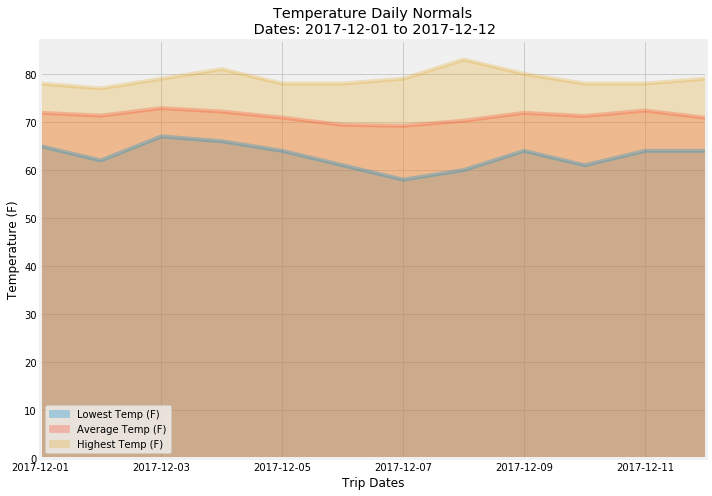

In [52]:
# Graph the data

daily_graph = trip_daily_normals_df.plot(kind='area', 
                                         figsize=(10,7), 
                                         alpha=.3, 
                                         stacked=False, 
                                         x_compat=True, 
                                         title="Temperature Daily Normals\n Dates: 2017-12-01 to 2017-12-12"
                                        )

plt.ylabel("Temperature (F)")

plt.tight_layout()

plt.savefig("Images/Temperature_Daily_Normals.png")

plt.show(daily_graph)

plt.close()